# RecMetrics Example

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from surprise import SVD, Dataset, Reader
from surprise.model_selection import train_test_split

import recmetrics


# MovieLense Dataset
Using the MovieLens 20M Dataset dataset for examples. You can download this data here: https://grouplens.org/datasets/movielens/20m/

In [2]:
# ratings = pd.read_csv('../movie_similarity_flask_api/data/ml-20m/ratings.csv')
ratings = pd.read_csv('./ml-20m/ratings.csv')
ratings = ratings.query('rating >=3')
ratings.reset_index(drop=True, inplace=True)

In [3]:
#only consider ratings from users who have rated over n movies
n=1000
users = ratings.userId.value_counts()
users = users[users>n].index.tolist()

In [4]:
ratings = ratings.query('userId in @users')
print(ratings.shape)
ratings.head(3)

(1317902, 4)


,userId,movieId,rating,timestamp
15918,156,1,5.0,1037739266
15919,156,2,5.0,1040937649
15920,156,4,3.0,1038801803


In [5]:
# get movie features

rated_movies = ratings.movieId.tolist()
# movies = pd.read_csv('../movie_similarity_flask_api/data/ml-20m/movies.csv')
movies = pd.read_csv('./ml-20m/movies.csv')
movies = movies.query('movieId in @rated_movies')
movies.set_index("movieId", inplace=True, drop=True)

movies = movies.genres.str.split("|", expand=True)
movies.reset_index(inplace=True)
movies = pd.melt(movies, id_vars='movieId', value_vars=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

movies.drop_duplicates("movieId", inplace=True)
movies.set_index('movieId', inplace=True)

movies = pd.get_dummies(movies.value)
#movies = movies[['Action', 'Romance', 'Western', 'Comedy', 'Crime']]
movies.head()

,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieId,,,,,,,,,,,,,,,,,,,,
1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Long Tail Plot Example

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


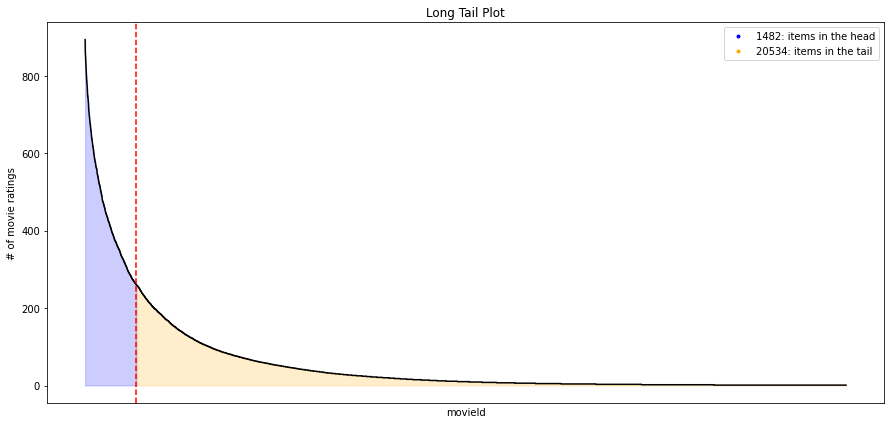

In [6]:
fig = plt.figure(figsize=(15, 7))
recmetrics.long_tail_plot(df=ratings, 
             item_id_column="movieId", 
             interaction_type="movie ratings", 
             percentage=0.5,
             x_labels=False)

# Collaborative Filter Recommender
Creating a simple CF to demonstrate recommender metrics in action. I've implemented collaborative filtering using a SVD approach in the surprise package. The surprise package also takes care of the test train split. The collaborative filter transforms user-item interactions into latent space, and reconstructs the user-item matrix to impute ratings missing movie ratings. The predicted rating is the dot product between the user and movie vectors in latent space. 

In [7]:
#format data for surprise
reader = Reader(rating_scale=(0, 5))
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)
trainset, testset = train_test_split(data, test_size=0.25)

In [8]:
#train SVD recommender 
algo = SVD()
algo.fit(trainset)

In [9]:
#make predictions on test set. 
test = algo.test(testset)
test = pd.DataFrame(test)
test.drop("details", inplace=True, axis=1)
test.columns = ['userId', 'movieId', 'actual', 'cf_predictions']
test.head()

,userId,movieId,actual,cf_predictions
0,15718,8998,4.5,4.170425
1,100781,4336,4.0,3.671811
2,68026,5484,4.5,3.821720
3,74966,2437,3.0,3.382269
4,8405,6896,5.0,4.192129


In [10]:
#evaluate model with MSE and RMSE
print("MSE: ", recmetrics.mse(test.actual, test.cf_predictions))
print("RMSE: ", recmetrics.rmse(test.actual, test.cf_predictions))

MSE:  0.26695930853691774
RMSE:  0.5166810510720494


In [11]:
#create model (matrix of predicted values)
cf_model = test.pivot_table(index='userId', columns='movieId', values='cf_predictions').fillna(0)

In [12]:
def get_users_predictions(user_id, n, model):
    recommended_items = pd.DataFrame(model.loc[user_id])
    recommended_items.columns = ["predicted_rating"]
    recommended_items = recommended_items.sort_values('predicted_rating', ascending=False)    
    recommended_items = recommended_items.head(n)
    return recommended_items.index.tolist()

In [13]:
#get example prediction
get_users_predictions(156, 10, cf_model)

[2571, 1198, 50, 1291, 480, 1704, 1210, 1234, 1, 1221]

In [14]:
test.head()

,userId,movieId,actual,cf_predictions
0,15718,8998,4.5,4.170425
1,100781,4336,4.0,3.671811
2,68026,5484,4.5,3.821720
3,74966,2437,3.0,3.382269
4,8405,6896,5.0,4.192129


In [15]:
# test.copy().groupby("userId")["movieId"].apply(list)
test = test.copy().groupby('userId', as_index=False)['movieId'].agg({'actual': (lambda x: list(set(x)))})

In [16]:
test = test.set_index("userId")

In [17]:
#format test data
# test = test.copy().groupby('userId')['movieId'].agg({'actual': (lambda x: list(set(x)))})
# test = test.copy().groupby("userId")["movieId"].apply(list)

# make recommendations for all members in the test data
cf_recs = [] = []
for user in test.index:
    cf_predictions = get_users_predictions(user, 10, cf_model)
    cf_recs.append(cf_predictions)
        
test['cf_predictions'] = cf_recs
test.head()

,actual,cf_predictions
userId,,
156,"[1, 6156, 2062, 16, 18, 2071, 2072, 2076, 4129...","[2571, 1198, 50, 1291, 480, 1704, 1210, 1234, ..."
208,"[69122, 83976, 2571, 524, 1036, 14, 5135, 529,...","[1198, 923, 922, 1196, 904, 593, 6016, 750, 12..."
359,"[1, 33794, 6659, 39427, 32770, 5127, 6664, 308...","[1198, 1221, 4993, 7153, 5952, 593, 527, 2028,..."
394,"[26116, 6662, 2058, 44555, 1546, 1036, 60943, ...","[3739, 858, 296, 5291, 3134, 1288, 3730, 1256,..."
572,"[2561, 514, 3, 516, 54787, 5, 2, 5125, 1029, 5...","[50, 5952, 296, 2329, 81845, 1617, 8961, 1089,..."


# Popularity Recommender
Creating a simple popularity recommender to demonstrate recommender metrics in action. The popularity recommender simply recommends the top 10 movies to every user.

In [18]:
#make recommendations for all members in the test data
popularity_recs = ratings.movieId.value_counts().head(10).index.tolist()

pop_recs = []
for user in test.index:
    pop_predictions = popularity_recs
    pop_recs.append(pop_predictions)
        
test['pop_predictions'] = pop_recs
test.head()

,actual,cf_predictions,pop_predictions
userId,,,
156,"[1, 6156, 2062, 16, 18, 2071, 2072, 2076, 4129...","[2571, 1198, 50, 1291, 480, 1704, 1210, 1234, ...","[1198, 1270, 593, 2762, 318, 2571, 260, 1240, ..."
208,"[69122, 83976, 2571, 524, 1036, 14, 5135, 529,...","[1198, 923, 922, 1196, 904, 593, 6016, 750, 12...","[1198, 1270, 593, 2762, 318, 2571, 260, 1240, ..."
359,"[1, 33794, 6659, 39427, 32770, 5127, 6664, 308...","[1198, 1221, 4993, 7153, 5952, 593, 527, 2028,...","[1198, 1270, 593, 2762, 318, 2571, 260, 1240, ..."
394,"[26116, 6662, 2058, 44555, 1546, 1036, 60943, ...","[3739, 858, 296, 5291, 3134, 1288, 3730, 1256,...","[1198, 1270, 593, 2762, 318, 2571, 260, 1240, ..."
572,"[2561, 514, 3, 516, 54787, 5, 2, 5125, 1029, 5...","[50, 5952, 296, 2329, 81845, 1617, 8961, 1089,...","[1198, 1270, 593, 2762, 318, 2571, 260, 1240, ..."


# Random Recommender
Creating a simple random recommender to demonstrate recommender metrics in action. The random recommender simply recommends 10 random movies to every user.

In [19]:
#make recommendations for all members in the test data

ran_recs = []
for user in test.index:
    random_predictions = ratings.movieId.sample(10).values.tolist()
    ran_recs.append(random_predictions)
        
test['random_predictions'] = ran_recs
test.head()

,actual,cf_predictions,pop_predictions,random_predictions
userId,,,,
156,"[1, 6156, 2062, 16, 18, 2071, 2072, 2076, 4129...","[2571, 1198, 50, 1291, 480, 1704, 1210, 1234, ...","[1198, 1270, 593, 2762, 318, 2571, 260, 1240, ...","[3812, 3100, 594, 54503, 5147, 5527, 3441, 994..."
208,"[69122, 83976, 2571, 524, 1036, 14, 5135, 529,...","[1198, 923, 922, 1196, 904, 593, 6016, 750, 12...","[1198, 1270, 593, 2762, 318, 2571, 260, 1240, ...","[966, 1060, 4679, 555, 2303, 3468, 37855, 4927..."
359,"[1, 33794, 6659, 39427, 32770, 5127, 6664, 308...","[1198, 1221, 4993, 7153, 5952, 593, 527, 2028,...","[1198, 1270, 593, 2762, 318, 2571, 260, 1240, ...","[55830, 74532, 3101, 88810, 3101, 2688, 89470,..."
394,"[26116, 6662, 2058, 44555, 1546, 1036, 60943, ...","[3739, 858, 296, 5291, 3134, 1288, 3730, 1256,...","[1198, 1270, 593, 2762, 318, 2571, 260, 1240, ...","[586, 1291, 858, 1674, 115210, 47274, 2917, 97..."
572,"[2561, 514, 3, 516, 54787, 5, 2, 5125, 1029, 5...","[50, 5952, 296, 2329, 81845, 1617, 8961, 1089,...","[1198, 1270, 593, 2762, 318, 2571, 260, 1240, ...","[3793, 3186, 26540, 1442, 1747, 3198, 6863, 82..."


# Recall

In [20]:
actual = test.actual.values.tolist()
cf_predictions = test.cf_predictions.values.tolist()
pop_predictions = test.pop_predictions.values.tolist()
random_predictions = test.random_predictions.values.tolist()

In [21]:
pop_mark = []
for K in np.arange(1, 11):
    pop_mark.extend([recmetrics.mark(actual, pop_predictions, k=K)])
pop_mark

[0.0008039299013778566,
 0.0012356193520245266,
 0.0015930307198543478,
 0.0019056764729016799,
 0.0021648846616618596,
 0.0024109894797916046,
 0.002664498342446852,
 0.0028817492728353245,
 0.0031296745593308883,
 0.0033815424291710125]

In [22]:
random_mark = []
for K in np.arange(1, 11):
    random_mark.extend([recmetrics.mark(actual, random_predictions, k=K)])
random_mark

[0.000246416505758053,
 0.0003786980041456078,
 0.0004627367032386646,
 0.000543016492428198,
 0.000615509606742623,
 0.0006574686673610069,
 0.0007097893591059847,
 0.0007599713991185656,
 0.0008094572516310016,
 0.0008507403987598606]

In [23]:
cf_mark = []
for K in np.arange(1, 11):
    cf_mark.extend([recmetrics.mark(actual, cf_predictions, k=K)])
cf_mark

[0.003080858116097662,
 0.006161716232195324,
 0.009242574348292985,
 0.012323432464390648,
 0.01540429058048831,
 0.01848514869658597,
 0.021566006812683634,
 0.024646864928781296,
 0.027727723044878954,
 0.03080858116097662]

# Mark Plot

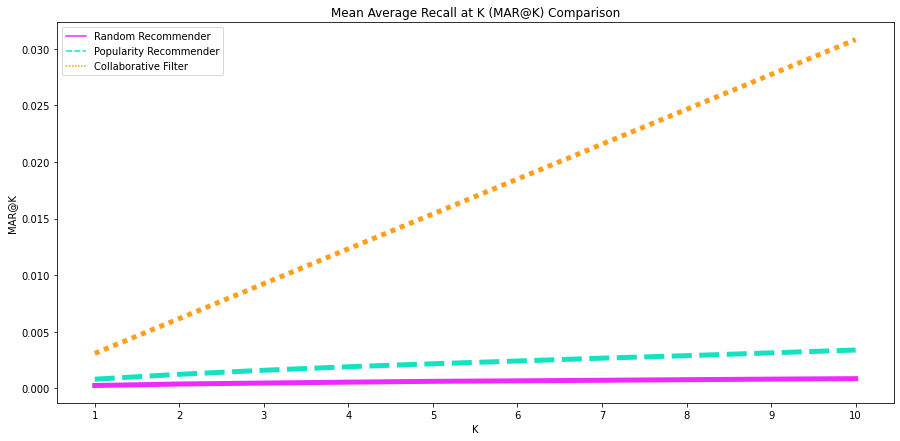

In [24]:
mark_scores = [random_mark, pop_mark, cf_mark]
index = range(1,10+1)
names = ['Random Recommender', 'Popularity Recommender', 'Collaborative Filter']

fig = plt.figure(figsize=(15, 7))
recmetrics.mark_plot(mark_scores, model_names=names, k_range=index)

# Prediction Coverage

In [25]:
catalog = ratings.movieId.unique().tolist()
random_coverage = recmetrics.prediction_coverage(ran_recs, catalog)
pop_coverage = recmetrics.prediction_coverage(pop_recs, catalog)
cf_coverage = recmetrics.prediction_coverage(cf_recs, catalog)

# Catalog Coverage

In [26]:
# N=100 observed recommendation lists
random_cat_coverage = recmetrics.catalog_coverage(ran_recs, catalog, 100)
pop_cat_coverage = recmetrics.catalog_coverage(pop_recs, catalog, 100)
cf_cat_coverage = recmetrics.catalog_coverage(cf_recs, catalog, 100)

# Coverage Plot

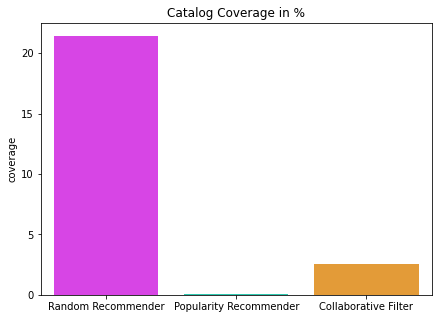

In [27]:
# plot of prediction coverage
coverage_scores = [random_coverage, pop_coverage, cf_coverage]
model_names = ['Random Recommender', 'Popularity Recommender', 'Collaborative Filter']

fig = plt.figure(figsize=(7, 5))
recmetrics.coverage_plot(coverage_scores, model_names)

# Novelty

In [28]:
nov = ratings.movieId.value_counts()
pop = dict(nov)

In [29]:
random_novelty,random_mselfinfo_list = recmetrics.novelty(ran_recs, pop, len(users), 10)
pop_novelty,pop_mselfinfo_list = recmetrics.novelty(pop_recs, pop, len(users), 10)
cf_novelty,cf_mselfinfo_list = recmetrics.novelty(cf_recs, pop, len(users), 10)

In [30]:
print(random_novelty, pop_novelty, cf_novelty)

2.2787753612437953 0.10697151566593387 0.6890422947462554


# Personalization

In [31]:
example_predictions = [
    ['1', '2', 'C', 'D'],
    ['4', '3', 'm', 'X'],
    ['7', 'B', 't', 'X']
]

In [32]:
recmetrics.personalization(predicted=example_predictions)

0.9166666666666666

# Intra-list Similarity

In [33]:
example_predictions = [
    [3, 7, 5, 9],
    [9, 6, 12, 623],
    [7, 894, 6, 623]
]

In [34]:
feature_df = movies[['Action', 'Comedy', 'Romance']]

In [35]:
recmetrics.intra_list_similarity(example_predictions, feature_df)

0.27777777777777773

# Classification Probability Plot

In [36]:
#make fake classification probability data
class_one_probs = np.random.normal(loc=.7, scale=0.1, size=1000)
class_zero_probs = np.random.normal(loc=.3, scale=0.1, size=1000)
actual = [1] * 1000
class_zero_actual = [0] * 1000
actual.extend(class_zero_actual)

pred_df = pd.DataFrame([np.concatenate((class_one_probs, class_zero_probs), axis=None), actual]).T
pred_df.columns = ["predicted", "truth"]
pred_df.head()

,predicted,truth
0,0.659372,1.0
1,0.855294,1.0
2,0.696381,1.0
3,0.687016,1.0
4,0.620887,1.0


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


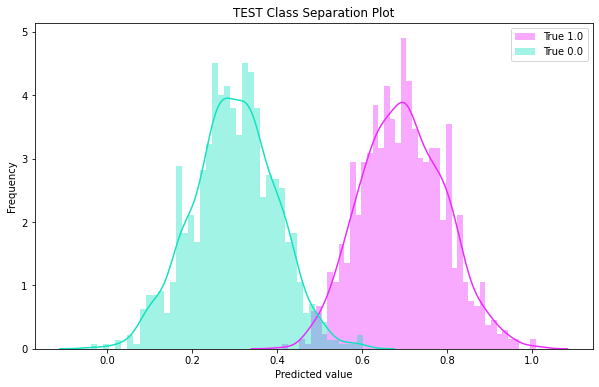

In [37]:
# recmetrics.class_separation_plot(pred_df, n_bins=45, class0_label="True class 0", class1_label="True class 1")
recmetrics.class_separation_plot(pred_df, n_bins=45, title="TEST Class Separation Plot")

# ROC Plot

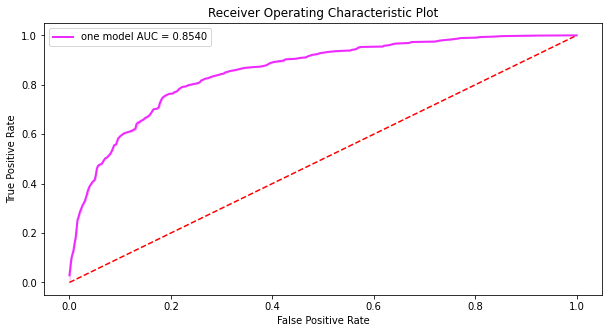

In [38]:
model_probs = np.concatenate([np.random.normal(loc=.2, scale=0.5, size=500), np.random.normal(loc=.9, scale=0.5, size=500)])
actual = [0] * 500
class_zero_actual = [1] * 500
actual.extend(class_zero_actual)

recmetrics.roc_plot(actual, model_probs, model_names="one model",  figsize=(10, 5))

# Precision Recall Curve

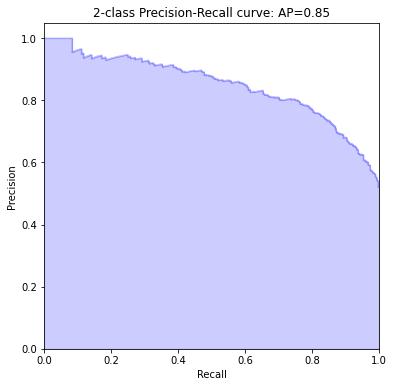

In [39]:
recmetrics.precision_recall_plot(targs=actual, preds=model_probs)

# Confusion Matrix

coming soon....

# Rank Order Analysis 

coming soon....